# This Notebook contains code to train mask classifiers the compiled image dataset

Face Analysis
* [Feature Extraction](#feat_ext)
* [Machine Learning Classifiers](#ml) 
* [Deep Learning with Keras](#dl)

Face Analysis with Additional Mask Annotation
* TODO: need to complete this part

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

from mtcnn.mtcnn import MTCNN # TODO: what is this?

https://github.com/prajnasb/observations

In [2]:
train = pd.read_csv('../Dataset/compare_to_published_datasets/rwmfd_labels_cropped.csv')

display(train)



name                                     image_file_dir  \
0    0001_0018.jpg  ../Dataset/compare_to_published_datasets/rwmfd...   
1    0001_0020.jpg  ../Dataset/compare_to_published_datasets/rwmfd...   
2    0001_0021.jpg  ../Dataset/compare_to_published_datasets/rwmfd...   
3         0001.jpg  ../Dataset/compare_to_published_datasets/rwmfd...   
4    0002_0003.jpg  ../Dataset/compare_to_published_datasets/rwmfd...   
..             ...                                                ...   
109  Untitled5.png  ../Dataset/compare_to_published_datasets/rwmfd...   
110  Untitled6.png  ../Dataset/compare_to_published_datasets/rwmfd...   
111  Untitled7.png  ../Dataset/compare_to_published_datasets/rwmfd...   
112  Untitled8.png  ../Dataset/compare_to_published_datasets/rwmfd...   
113  Untitled9.png  ../Dataset/compare_to_published_datasets/rwmfd...   

          classname  
0    face_with_mask  
1    face_with_mask  
2    face_with_mask  
3    face_with_mask  
4    face_with_mask  
..              ...  
109  face_with_mask  
110  face_with_mask  
111  face_with_mask  
112  face_with_mask  
113  face_with_mask  

[114 rows x 3 columns]

# Plot Some Annotations

0001_0021.jpg has 1 label(s)
2    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


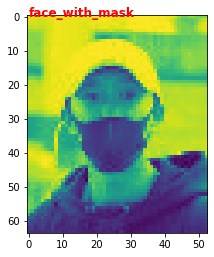

0002_0014.jpg has 1 label(s)
13    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


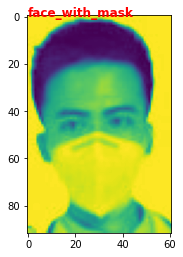

0002_0003.jpg has 1 label(s)
4    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


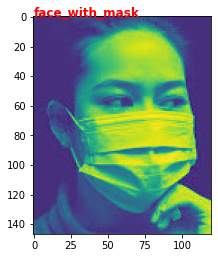

0002_0012.jpg has 1 label(s)
11    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


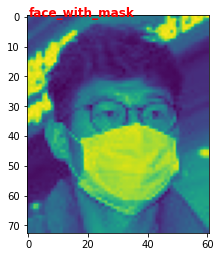

0004_0008.jpg has 1 label(s)
42    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


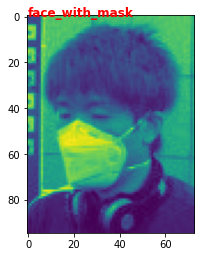

0017_0004.jpg has 1 label(s)
99    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


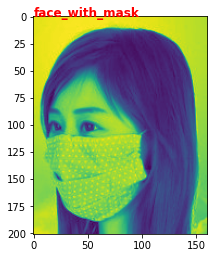

0007_0003.jpg has 1 label(s)
78    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


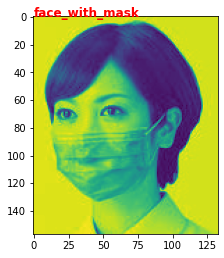

0004.jpg has 1 label(s)
50    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


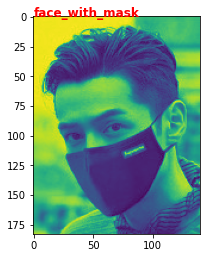

0003_0015.jpg has 1 label(s)
32    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


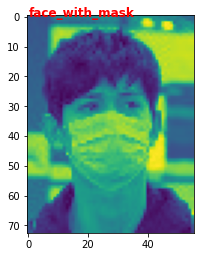

0002_0011.jpg has 1 label(s)
10    ../Dataset/compare_to_published_datasets/rwmfd...
Name: image_file_dir, dtype: object
['face_with_mask']


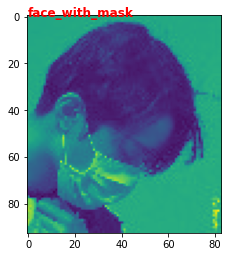

In [3]:
import random
def plot_image_with_all_bboxes(img_nm):
    dat = train[train['name'] == img_nm]
    print(img_nm,"has",len(dat),'label(s)')
    print(dat['image_file_dir']+img_nm)
    
    img = cv2.imread(dat.iloc[0]['image_file_dir']+img_nm,cv2.IMREAD_GRAYSCALE)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    class_name_ls = []
    for index,row in dat.iterrows():
#         rect = patches.Rectangle(
#             (row['x1'],row['x2']),
#             row['y1'],
#             row['y2'],
#             linewidth=2,edgecolor='r',facecolor='none')
#         ax.add_patch(rect)
        ax.text(0,0, row['classname'], fontsize=12,color='r',fontweight='bold')
        class_name_ls.append(row['classname'])
    print(class_name_ls)
    plt.show()
name_ls =list(set(train['name']))
random.shuffle(name_ls)

for f in name_ls[0:10]:
    plot_image_with_all_bboxes(f)
    
    

# Plot Distribution of the Labels 

face_with_mask    114
Name: classname, dtype: int64


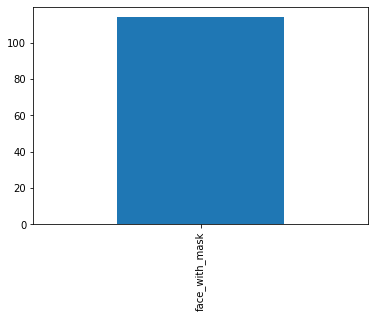

In [4]:
train.classname.value_counts().plot(kind='bar')
print(train.classname.value_counts())


In [5]:
print(set(train['classname']))

{'face_with_mask'}


<a id='feat_ext'></a>
# Extract only faces from images
(This may take several minutes to run)

In [6]:
train.iloc[0]

name                                                  0001_0018.jpg
image_file_dir    ../Dataset/compare_to_published_datasets/rwmfd...
classname                                            face_with_mask
Name: 0, dtype: object

In [7]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
img_size=224#50
data=[]
to_drop = []
    
for index,row in train.iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#
    # crops the image to only include the face 
#     crop_image = img_array[row['x2']:(row['y2']+row['x2']),
#                            row['x1']:(row['y1']+row['x1'])]
    # resizes the image to 50x50
    try:
        new_img_array=cv2.resize(img_array,(img_size,img_size))
    #         plt.imshow(new_img_array)
    #         plt.show()
        data.append([new_img_array,row['classname']])#new_img_array[1]])
    except:
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data.append(-1)
    




# Some annotations of small faces cannot be included as we cannot generate a 50x50 image with them so will exclude for now
NOTE: other annotations of these same image files will be retained as they are valuable to our analysis

# Plot Some Extracted Faces
two from each dataset

In [8]:
# get INDICIES of two images from each data source
index_ls = []
for d in list(set(train['image_file_dir'])):# will be different for each dataset
    index_ls+=list(train[train['image_file_dir'] == d].index)[0:2]


[[[198 195 204]
  [199 196 204]
  [200 198 205]
  ...
  [181 181 197]
  [175 175 191]
  [171 171 187]]

 [[195 192 201]
  [196 194 202]
  [198 197 203]
  ...
  [181 181 197]
  [176 176 192]
  [173 173 189]]

 [[194 191 199]
  [194 193 200]
  [196 195 202]
  ...
  [179 179 195]
  [176 176 192]
  [174 174 190]]

 ...

 [[150 168 209]
  [150 168 209]
  [151 169 210]
  ...
  [ 89  89  88]
  [ 90  90  89]
  [ 91  91  89]]

 [[148 167 206]
  [149 167 207]
  [150 169 208]
  ...
  [ 90  92  90]
  [ 91  93  91]
  [ 91  93  91]]

 [[150 169 207]
  [151 170 208]
  [152 171 209]
  ...
  [ 90  93  91]
  [ 91  94  92]
  [ 92  95  93]]]
Shape: (224, 224, 3)


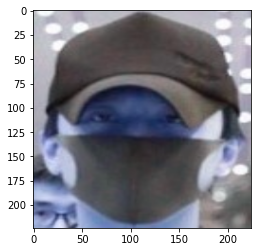


[[[214 196 213]
  [214 196 213]
  [214 196 213]
  ...
  [221 201 206]
  [221 201 206]
  [221 201 206]]

 [[214 196 213]
  [214 196 213]
  [214 196 213]
  ...
  [221 201 206]
  [221 201 206]
  [221 201 206]]

 [[214 196 213]
  [214 196 213]
  [214 196 213]
  ...
  [221 201 206]
  [221 201 206]
  [221 201 206]]

 ...

 [[253 255 247]
  [253 255 247]
  [252 254 247]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[253 255 247]
  [253 255 247]
  [252 254 246]
  ...
  [249 249 249]
  [249 249 249]
  [249 249 249]]

 [[253 255 247]
  [253 255 247]
  [252 254 246]
  ...
  [249 249 249]
  [249 249 249]
  [249 249 249]]]
Shape: (224, 224, 3)


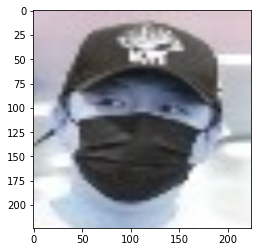

In [9]:
# show a few extracted faces:
for i in index_ls:
    print(data[i][0])
    print("Shape:",data[i][0].shape)
    plt.imshow(data[i][0])
    plt.show()
    print()


In [10]:
# Extracts labels (mask/no mask) and features (50x50 vector of face image) and places them into x and y lists respectively
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)
print("y:",y)
print("x:",x[0:5])

y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
x: [array([[[198, 195, 204],
        [199, 196, 204],
        [200, 198, 205],
        ...,
        [181, 181, 197],
        [175, 175, 191],
        [171, 171, 187]],

       [[195, 192, 201],
        [196, 194, 202],
        [198, 197, 203],
        ...,
        [181, 181, 197],
        [176, 176, 192],
        [173, 173, 189]],

       [[194, 191, 199],
        [194, 193, 200],
        [196, 195, 202],
        ...,
        [179, 179, 195],
        [176, 176, 192],
        [174, 174, 190]],

       ...,

       [[150, 168, 209],
        [150, 168, 209],
        [151, 169, 210],
        ...,
        [ 89,  89,  88],
        [ 90,  90,  89],
        [ 91,  91,  89]],

       [[148, 167, 206],
        [149, 167, 207],
        [150, 169, 208],
        ...,

# Add more mask data

In [11]:
train_addmask = pd.read_csv('compiled_labels_km-annotated.csv')

display(train_addmask)

name   x1   x2   y1   y2       classname  \
0        1801.jpg  451  186  444  511    face_no_mask   
1        1802.jpg  160  151  108  114       face_mask   
2        1802.jpg  110   71  163  201  face_with_mask   
3        1803.jpg  147  200  141  120       face_mask   
4        1803.jpg  126   75  177  258  face_with_mask   
...           ...  ...  ...  ...  ...             ...   
20312  new_76.jpg  191  187  282  382    face_no_mask   
20313  new_78.jpg  126  200  335  370    face_no_mask   
20314  new_79.jpg  138  212  305  332    face_no_mask   
20315  new_90.jpg  133  263  346  316    face_no_mask   
20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
20312       ../Dataset/yolo/images/valid/  
20313       ../Dataset/yolo/images/valid/  
20314       ../Dataset/yolo/images/valid/  
20315       ../Dataset/yolo/images/valid/  
20316       ../Dataset/yolo/images/valid/  

[20317 rows x 7 columns]

In [12]:
train_addmask = train_addmask.reset_index()
# only keep faces with masks
train_addmask= train_addmask[train_addmask['classname'] == 'face_with_mask']
display(train_addmask)

index        name   x1   x2   y1   y2       classname  \
2          2    1802.jpg  110   71  163  201  face_with_mask   
4          4    1803.jpg  126   75  177  258  face_with_mask   
6          6    1804.jpg  112  113  150  194  face_with_mask   
7          7    1805.jpg  728  180  125  156  face_with_mask   
10        10    1806.jpg  509  184  108  129  face_with_mask   
...      ...         ...  ...  ...  ...  ...             ...   
20302  20302  new_55.jpg  316  322  333  315  face_with_mask   
20303  20303  new_59.jpg  582  131  179  170  face_with_mask   
20304  20304  new_62.jpg  507   97   84   97  face_with_mask   
20305  20305  new_63.jpg  518  274  208  197  face_with_mask   
20306  20306  new_65.jpg  626  145   46   48  face_with_mask   

                           image_file_dir  
2      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
6      ../Dataset/mask_image_data/images/  
7      ../Dataset/mask_image_data/images/  
10     ../Dataset/mask_image_data/images/  
...                                   ...  
20302       ../Dataset/yolo/images/valid/  
20303       ../Dataset/yolo/images/valid/  
20304       ../Dataset/yolo/images/valid/  
20305       ../Dataset/yolo/images/valid/  
20306       ../Dataset/yolo/images/valid/  

[11767 rows x 8 columns]

In [13]:
masked_face_a = [x for x in list(train_addmask['name']) if "asian" in x]
train_addmask = train_addmask[train_addmask['name'].isin(masked_face_a) ]



In [14]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
img_size=224#50
data_addmask=[]
to_drop = []
    
for index,row in train_addmask.iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#
    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]
    # resizes the image to 50x50
    try:
        new_img_array=cv2.resize(crop_image,(img_size,img_size))
    #         plt.imshow(new_img_array)
    #         plt.show()
        data_addmask.append([new_img_array,row['classname']])#new_img_array[1]])
    except:
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data_addmask.append(-1)
    







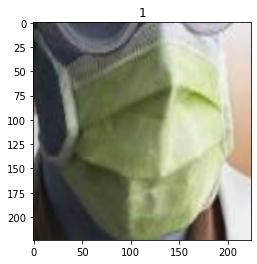

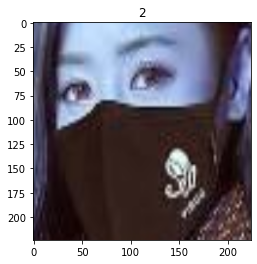

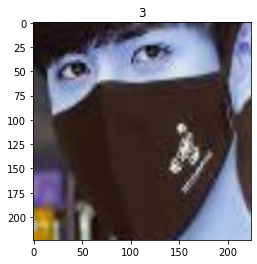

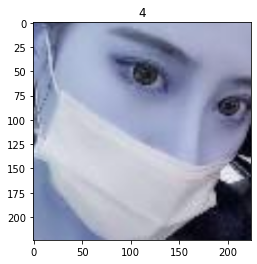

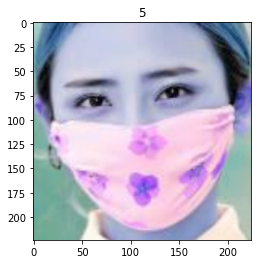

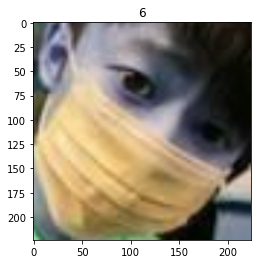

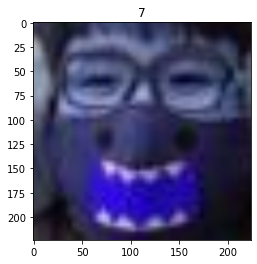

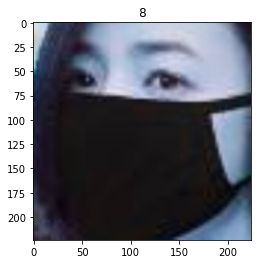

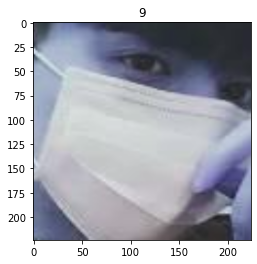

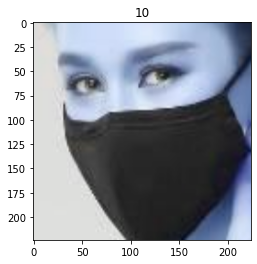

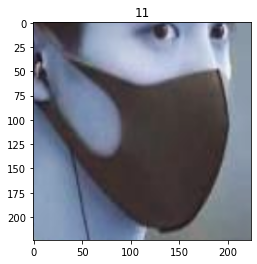

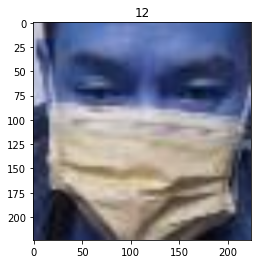

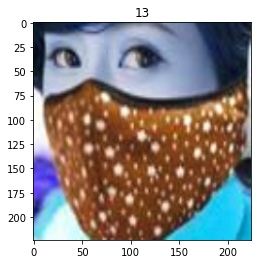

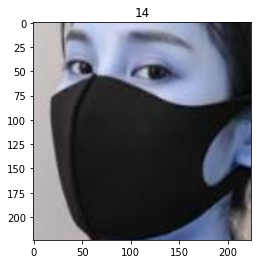

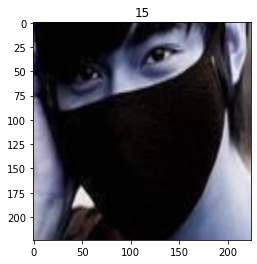

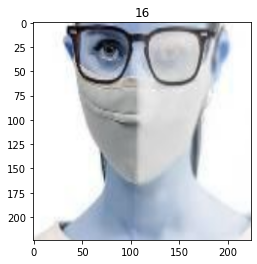

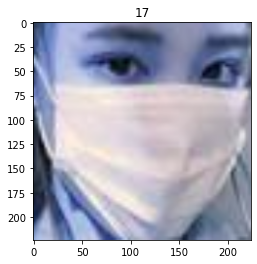

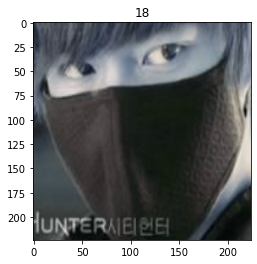

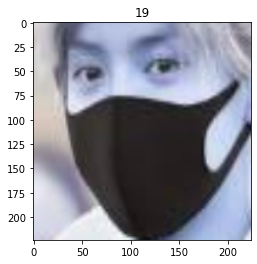

In [15]:
# show a few extracted faces:
for i in range(1,20):
    plt.imshow(data_addmask[i][0])
    plt.title(i)
    plt.show()



In [16]:
# Exclude annotations that could not be formatted
train_addmask = train_addmask.drop(to_drop)

initial_len = len(data_addmask)
data_addmask = [x for x in data_addmask if x != -1]

print("Dropped",len(to_drop),"images from train_unmasked")
print("Dropped",initial_len-len(data_addmask),"faces from data")


Dropped 0 images from train_unmasked
Dropped 0 faces from data


In [17]:
# Extracts labels (mask/no mask) and features (50x_addmask50 vector of face image) and places them into x_addmask and y_addmask lists respectively_addmask
x_addmask=[]
y_addmask=[]
for features, labels in data_addmask:
    x_addmask.append(features)
    y_addmask.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y_addmask=lbl.fit_transform(y_addmask)
print("y_addmask:",y_addmask)
print("x_addmask:",x_addmask[0:5])






y_addmask: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_addmask: [array([[[146, 169, 207],
        [146, 169, 207],
        [145, 168, 206],
        ...,
        [251, 250, 252],
        [25

# add data from our own dataset (faces without masks) to use in training - take equivalent number

In [18]:
train_unmasked = pd.read_csv('compiled_labels_km-annotated.csv')

display(train_unmasked)

name   x1   x2   y1   y2       classname  \
0        1801.jpg  451  186  444  511    face_no_mask   
1        1802.jpg  160  151  108  114       face_mask   
2        1802.jpg  110   71  163  201  face_with_mask   
3        1803.jpg  147  200  141  120       face_mask   
4        1803.jpg  126   75  177  258  face_with_mask   
...           ...  ...  ...  ...  ...             ...   
20312  new_76.jpg  191  187  282  382    face_no_mask   
20313  new_78.jpg  126  200  335  370    face_no_mask   
20314  new_79.jpg  138  212  305  332    face_no_mask   
20315  new_90.jpg  133  263  346  316    face_no_mask   
20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
20312       ../Dataset/yolo/images/valid/  
20313       ../Dataset/yolo/images/valid/  
20314       ../Dataset/yolo/images/valid/  
20315       ../Dataset/yolo/images/valid/  
20316       ../Dataset/yolo/images/valid/  

[20317 rows x 7 columns]

In [19]:
train_unmasked = train_unmasked.reset_index()
# only keep faces without masks
train_unmasked= train_unmasked[train_unmasked['classname'] == 'face_no_mask']
display(train_unmasked)

index        name   x1   x2   y1   y2     classname  \
0          0    1801.jpg  451  186  444  511  face_no_mask   
12        12    1808.jpg    3  650  335  724  face_no_mask   
13        13    1808.jpg   80  243  802  915  face_no_mask   
14        14    1809.jpg  915   78  504  664  face_no_mask   
25        25    1811.jpg  435   83  148  193  face_no_mask   
...      ...         ...  ...  ...  ...  ...           ...   
20312  20312  new_76.jpg  191  187  282  382  face_no_mask   
20313  20313  new_78.jpg  126  200  335  370  face_no_mask   
20314  20314  new_79.jpg  138  212  305  332  face_no_mask   
20315  20315  new_90.jpg  133  263  346  316  face_no_mask   
20316  20316  new_94.jpg  124  269  334  297  face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
12     ../Dataset/mask_image_data/images/  
13     ../Dataset/mask_image_data/images/  
14     ../Dataset/mask_image_data/images/  
25     ../Dataset/mask_image_data/images/  
...                                   ...  
20312       ../Dataset/yolo/images/valid/  
20313       ../Dataset/yolo/images/valid/  
20314       ../Dataset/yolo/images/valid/  
20315       ../Dataset/yolo/images/valid/  
20316       ../Dataset/yolo/images/valid/  

[2872 rows x 8 columns]

In [20]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
img_size=224#50
data_unmasked=[]
to_drop = []
    
for index,row in train_unmasked.iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#
    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]
    # resizes the image to 50x50
    try:
        new_img_array=cv2.resize(crop_image,(img_size,img_size))
    #         plt.imshow(new_img_array)
    #         plt.show()
        data_unmasked.append([new_img_array,row['classname']])#new_img_array[1]])
    except:
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data_unmasked.append(-1)
    






# Pick only 100 asian faces without masks

In [21]:
asian_data_unmasked = []
# show a few extracted faces:
asian_face_index = [11,46,67,73,78,79,80,109,125,136,141,145,149,151,155,161,162,168,177,192,222,227,228,237,240,244,247,279,280,295,297,304,306,312,335,339,352,356,382,388,389,399,413,416,424,434,440,484,515,520,544,545,556,564,565,567,575,607,613,619,624,627,628,629,639,652,653,660,664,675,695,705,714,722,731,744,763,772,773,834,930,965,1024,1064,1083,1084,1199,1236,1275,1277,1284,1288,1318,1333,1335,1337,1348,1352]
for i in asian_face_index:
#     print(data_unmasked[i][0])
#     print("Shape:",data_unmasked[i][0].shape)
    
#     plt.imshow(data_unmasked[i][0])
    asian_data_unmasked.append(data_unmasked[i])
#     plt.title(i)
#     plt.show()

asian_data_unmasked

[[array([[[ 2,  3,  0],
          [ 2,  3,  0],
          [ 3,  3,  0],
          ...,
          [13, 10,  4],
          [13, 10,  3],
          [13, 10,  2]],
  
         [[ 2,  3,  0],
          [ 2,  3,  0],
          [ 3,  4,  0],
          ...,
          [13, 10,  4],
          [13, 10,  3],
          [13, 10,  2]],
  
         [[ 2,  3,  0],
          [ 2,  3,  0],
          [ 3,  4,  0],
          ...,
          [13, 10,  4],
          [13, 10,  3],
          [13, 10,  2]],
  
         ...,
  
         [[75, 73, 73],
          [77, 75, 76],
          [82, 80, 82],
          ...,
          [79, 68, 60],
          [75, 63, 57],
          [74, 62, 56]],
  
         [[71, 69, 70],
          [73, 71, 73],
          [77, 76, 78],
          ...,
          [78, 67, 60],
          [79, 67, 61],
          [80, 68, 62]],
  
         [[68, 67, 69],
          [70, 69, 71],
          [74, 73, 76],
          ...,
          [78, 66, 60],
          [82, 70, 64],
          [84, 72, 66]]], dtype=u

In [22]:
data_unmasked = asian_data_unmasked

In [23]:
# Exclude annotations that could not be formatted
train_unmasked = train_unmasked.drop(to_drop)

initial_len = len(data_unmasked)
data_unmasked = [x for x in data_unmasked if x != -1]

print("Dropped",len(to_drop),"images from train_unmasked")
print("Dropped",initial_len-len(data_unmasked),"faces from data")



Dropped 0 images from train_unmasked
Dropped 0 faces from data


In [24]:
len(data_unmasked)

98

In [25]:
# Extracts labels (mask/no mask) and features (50x_unmasked50 vector of face image) and places them into x_unmasked and y_unmasked lists respectively_unmasked
x_unmasked=[]
y_unmasked=[]
for features, labels in data_unmasked:
    x_unmasked.append(features)
    y_unmasked.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y_unmasked=lbl.fit_transform(y_unmasked)
print("y_unmasked:",y_unmasked)
print("x_unmasked:",x_unmasked[0:5])





y_unmasked: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_unmasked: [array([[[ 2,  3,  0],
        [ 2,  3,  0],
        [ 3,  3,  0],
        ...,
        [13, 10,  4],
        [13, 10,  3],
        [13, 10,  2]],

       [[ 2,  3,  0],
        [ 2,  3,  0],
        [ 3,  4,  0],
        ...,
        [13, 10,  4],
        [13, 10,  3],
        [13, 10,  2]],

       [[ 2,  3,  0],
        [ 2,  3,  0],
        [ 3,  4,  0],
        ...,
        [13, 10,  4],
        [13, 10,  3],
        [13, 10,  2]],

       ...,

       [[75, 73, 73],
        [77, 75, 76],
        [82, 80, 82],
        ...,
        [79, 68, 60],
        [75, 63, 57],
        [74, 62, 56]],

       [[71, 69, 70],
        [73, 71, 73],
        [77, 76, 78],
        ...,
        [78, 67, 60],
        [79, 67, 61],
        [80, 68, 62]],

       [[68, 67, 69],
     

In [26]:
# # # combine unmasked with masked datasets
x_comb = (list(x_unmasked)+list(x)+list(x_addmask))
y_comb = ([0]*len(x_unmasked)+[1]*len(x)+[1]*len(x_addmask)) ## so unmasked is 0
x_comb

[array([[[ 2,  3,  0],
         [ 2,  3,  0],
         [ 3,  3,  0],
         ...,
         [13, 10,  4],
         [13, 10,  3],
         [13, 10,  2]],
 
        [[ 2,  3,  0],
         [ 2,  3,  0],
         [ 3,  4,  0],
         ...,
         [13, 10,  4],
         [13, 10,  3],
         [13, 10,  2]],
 
        [[ 2,  3,  0],
         [ 2,  3,  0],
         [ 3,  4,  0],
         ...,
         [13, 10,  4],
         [13, 10,  3],
         [13, 10,  2]],
 
        ...,
 
        [[75, 73, 73],
         [77, 75, 76],
         [82, 80, 82],
         ...,
         [79, 68, 60],
         [75, 63, 57],
         [74, 62, 56]],
 
        [[71, 69, 70],
         [73, 71, 73],
         [77, 76, 78],
         ...,
         [78, 67, 60],
         [79, 67, 61],
         [80, 68, 62]],
 
        [[68, 67, 69],
         [70, 69, 71],
         [74, 73, 76],
         ...,
         [78, 66, 60],
         [82, 70, 64],
         [84, 72, 66]]], dtype=uint8),
 array([[[ 22,  35, 114],
         [ 21,  

<a id='split'></a>
### Partition Training set to use part for evaluating (because submission set is unlabelled)

In [66]:
len(list(x)[0:50])

50

In [96]:
# x_test = list(x_unmasked)[0:50]+list(x)[0:50]
# y_test = len(list(x_unmasked)[0:50])*[0]+len(list(x)[0:50])*[1]

# x_train = list(x_unmasked)[50:]+list(x)[50:]+list(x_addmask)
# # y_train = len(list(x_unmasked)[50:])*[0]+len(list(x)[50:])*[1]+len(list(x_addmask))*[1]




In [113]:
import numpy as np
from sklearn.model_selection import train_test_split
sz = 0.2# 0.8 # size of test set partition

x_train, x_test, y_train, y_test = train_test_split(
    x_comb, y_comb, test_size=sz)


print("Full labelled dataset size:",len(x_comb))
print("Splitting data into training/testing set with a "+str(sz*100)+"% partition")
print("Training set size:",len(x_train))
print("Test set size:",len(x_test))




Full labelled dataset size: 632
Splitting data into training/testing set with a 20.0% partition
Training set size: 505
Test set size: 127


In [114]:
x_test = list(x_unmasked)[0:50]+list(x)[0:50]
y_test = len(list(x_unmasked)[0:50])*[0]+len(list(x)[0:50])*[1]

<a id='dl'></a>

# Deep learning 

# Using Abdul's methods
[Partition Data](#split)

In [115]:
x_train = np.asarray(x_train)# set of 50x_train50 arrays representing pix_trainel intensities for each image
print("x.shape",x_train.shape)
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
print("y:",y_train)

# do same for test dataset
x_test = np.asarray(x_test)
print("\nx_test.shape",x_train.shape)

print("y_test:",y_test)

x.shape (505, 224, 224, 3)
y: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [116]:
#normalize the data
x_train = x_train/255.0

# do same for test dataset
x_test = x_test/255.0


In [117]:
y_train = np.array(y_train)
print (y_train.shape)

# do same for test dataset
y_test = np.array(y_test)
print (y_test.shape)


(505,)
(100,)


In [118]:
import pickle # module implements binary protocols

pickle_out = open("x_train-rmw.pickle",'wb') # "w" - Write - Opens a file for writing, creates the file if it does not ex_trainist . b = binary
pickle.dump(x_train,pickle_out)
print (pickle.dump(x_train,pickle_out))
pickle_out.close



None


<function BufferedWriter.close>

In [119]:
pickle_out = open('y_train-rmw.pickle','wb')
pickle.dump(y_train,pickle_out)
print (pickle.dump(y_train,pickle_out))
pickle_out.close

None


<function BufferedWriter.close>

In [120]:
pickle_in = open('x_train-rmw.pickle','rb')
x_train = pickle.load(pickle_in)
print(x_train)

pickle_in = open('y_train-rmw.pickle','rb')
#y = pickle.load(pickle_in)
y_train = pickle.load(file= pickle_in,  fix_imports=True)
print(y_train)




[[[[0.4        0.39215686 0.38823529]
   [0.41960784 0.41568627 0.40784314]
   [0.45490196 0.44705882 0.44313725]
   ...
   [0.27843137 0.27058824 0.26666667]
   [0.28627451 0.27843137 0.2745098 ]
   [0.29019608 0.28235294 0.27843137]]

  [[0.4        0.39215686 0.38823529]
   [0.42352941 0.41176471 0.40784314]
   [0.45490196 0.44705882 0.44313725]
   ...
   [0.2745098  0.26666667 0.2627451 ]
   [0.28235294 0.2745098  0.27058824]
   [0.28627451 0.27843137 0.2745098 ]]

  [[0.4        0.39215686 0.38823529]
   [0.42352941 0.41568627 0.41176471]
   [0.45490196 0.44705882 0.44313725]
   ...
   [0.27058824 0.2627451  0.25882353]
   [0.27843137 0.27058824 0.26666667]
   [0.28235294 0.2745098  0.27058824]]

  ...

  [[0.10588235 0.10588235 0.43137255]
   [0.11372549 0.10980392 0.43137255]
   [0.12156863 0.11764706 0.43529412]
   ...
   [0.78431373 0.75294118 0.7254902 ]
   [0.8        0.76862745 0.74117647]
   [0.80784314 0.77647059 0.74901961]]

  [[0.09411765 0.09019608 0.42352941]
   [0.1

## Deep learning model for training - Transfer Learning



In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [122]:
model = tf.keras.applications.mobilenet.MobileNet() # pre-trained model
#model = tensorflow.keras.applications.mobilenet.MobileNet() # pre-trained model
# to read https://deeplizard.com/learn/video/OO4HD-1wRN8



In [123]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

## Transfer learning

In [124]:
base_input = model.layers[0].input
base_input

<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>

In [125]:
base_output = model.layers[-4].output
base_output

<tf.Tensor 'dropout/cond_4/Identity:0' shape=(None, 1, 1, 1024) dtype=float32>

In [126]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) # 0 , 1
final_output = layers.Activation(activation='sigmoid')(final_output) # it was final_ouput 

In [127]:
# I create new model with my new layers 
new_model = keras.Model(inputs = base_input, outputs = final_output)



In [128]:
# I would chek the last layer (sigmoid)
just_to_check = new_model.layers[-1].output
just_to_check



<tf.Tensor 'activation_2/Sigmoid:0' shape=(None, 1) dtype=float32>

In [129]:
new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## settings for binary classificaiton (Face mask/without mask)

In [130]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





In [131]:
new_model.fit(x_train,y_train,epochs=1,validation_split= 0.1)
# TODO: remove validation split since we will validate on training or does this use it in the training?




15/15 [==============================] - 30s 2s/step - loss: 0.1346 - accuracy: 0.9405 - val_loss: 0.0971 - val_accuracy: 0.9608


In [132]:
new_model.save('my_model-rmw.h5')


## Evaluate model


In [133]:
# load model
new_model = tf.keras.models.load_model('my_model-rmw.h5')

In [134]:
# perform prediction
pred = new_model.predict(x=x_test,batch_size=32)



In [135]:
len(y_test)#[:,0])



100

In [136]:
len([int(round(x,0)) for x in list(pred[:,0])])

100

### ROC curve 
# ***NOT SURE IF ROC CURVE IS APPLICABLE TO THIS MODEL!!***


ROC curve data saved to: deep_learning_roc_curve-rmw.csv

Plot saved to: deep_learning_roc_curve-rmw.png


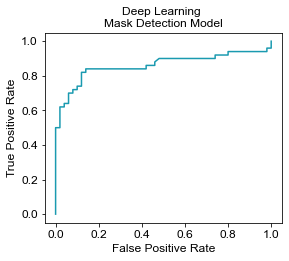

In [137]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, list(pred[:,0]))


### Plot Data ###
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import matplotlib
from matplotlib.gridspec import GridSpec
font = {'weight' : 'normal','size'   : 12,'family'   : "Arial"}
matplotlib.rc('font', **font)
fig = plt.figure()#figsize=(10,6))#(5,3.25))
ax = fig.add_subplot()
plt.plot(
    fpr,
    tpr,
#     '-o',#''.',
    color = '#1a9ab0',
#     label =None,
#     markersize=2,
)
# ax.set_ylim(0.0, 1.05)
ax.set_title("Deep Learning \n"+title,fontsize=12)

# ax.set_xlim(0.0, 1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
fig.set_size_inches(4.25,3.5)

# save roc curve values to csv so can plot with others later
data_file_out="deep_learning_roc_curve-rmw.csv"
pd.DataFrame({"fpr":fpr,"tpr":tpr}).to_csv(data_file_out)
print("\nROC curve data saved to:",data_file_out)
             
### Save Figure ###
img_fname = ("deep_learning_roc_curve-rmw"+'.png')
plt.savefig('plots/'+img_fname,
            bbox_inches="tight",dpi=300,transparent=True)
print("\nPlot saved to:",img_fname)
             

### Compute Scores

In [138]:
from sklearn import metrics

d = metrics.classification_report(y_test,
                                  [int(round(x,0)) for x in pred[:,0]],
                                  output_dict = True
                                 )

d = pd.DataFrame(d)
d = d.apply(lambda x: round(x,4))

display(d)




0        1  accuracy  macro avg  weighted avg
precision   0.8000   0.8667      0.83     0.8333        0.8333
recall      0.8800   0.7800      0.83     0.8300        0.8300
f1-score    0.8381   0.8211      0.83     0.8296        0.8296
support    50.0000  50.0000      0.83   100.0000      100.0000

### Plot Confusion Matrix

In [139]:
pred = list(pred.reshape(2925))

ValueError: cannot reshape array of size 100 into shape (2925,)

In [140]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,[int(round(x,0)) for x in pred[:,0]]) # true, predicted

array([[44,  6],
       [11, 39]])

TN: 44  FP: 6  FN: 11  TP: 39


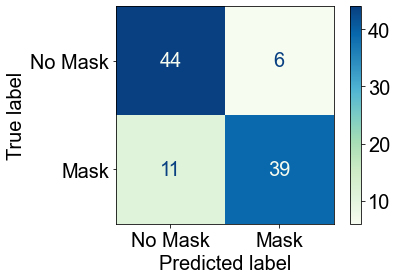

In [141]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial" # set default font to Arial
matplotlib.rcParams['font.family'] = "sans-serif" # ALWAYS use sans-serif fonts
matplotlib.rcParams['font.size'] = 20
fig, ax = plt.subplots()

cm = confusion_matrix(y_test,[int(round(x,0)) for x in pred[:,0]])#pred,y_test[:,0])
tn, fp, fn, tp = cm.ravel()
print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Mask","Mask"])
disp.plot(cmap='GnBu',ax=ax)
title = 'Mask Detection Model'
# ax.set_title('Title')
plt.savefig('plots/'+title.replace(" ","_")+"_confusion_matrix-rmw.png",dpi=300,bbox_inches="tight",transparent=True)



# Evaluate on Diverse Testing Set

In [104]:
train_eval = pd.read_csv('compiled_labels_km-annotated.csv')

display(train_eval)

name   x1   x2   y1   y2       classname  \
0        1801.jpg  451  186  444  511    face_no_mask   
1        1802.jpg  160  151  108  114       face_mask   
2        1802.jpg  110   71  163  201  face_with_mask   
3        1803.jpg  147  200  141  120       face_mask   
4        1803.jpg  126   75  177  258  face_with_mask   
...           ...  ...  ...  ...  ...             ...   
20312  new_76.jpg  191  187  282  382    face_no_mask   
20313  new_78.jpg  126  200  335  370    face_no_mask   
20314  new_79.jpg  138  212  305  332    face_no_mask   
20315  new_90.jpg  133  263  346  316    face_no_mask   
20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
20312       ../Dataset/yolo/images/valid/  
20313       ../Dataset/yolo/images/valid/  
20314       ../Dataset/yolo/images/valid/  
20315       ../Dataset/yolo/images/valid/  
20316       ../Dataset/yolo/images/valid/  

[20317 rows x 7 columns]

In [105]:
train_eval = train_eval.reset_index()
train_face_eval= train_eval[train_eval['classname'] != 'face_mask']
# Drop annotations for label face_other_covering
train_face_eval = train_face_eval[train_face_eval['classname']!='face_other_covering']
train_face_eval = train_face_eval.reset_index()
display(train_face_eval)




level_0  index        name   x1   x2   y1   y2       classname  \
0            0      0    1801.jpg  451  186  444  511    face_no_mask   
1            2      2    1802.jpg  110   71  163  201  face_with_mask   
2            4      4    1803.jpg  126   75  177  258  face_with_mask   
3            6      6    1804.jpg  112  113  150  194  face_with_mask   
4            7      7    1805.jpg  728  180  125  156  face_with_mask   
...        ...    ...         ...  ...  ...  ...  ...             ...   
14634    20312  20312  new_76.jpg  191  187  282  382    face_no_mask   
14635    20313  20313  new_78.jpg  126  200  335  370    face_no_mask   
14636    20314  20314  new_79.jpg  138  212  305  332    face_no_mask   
14637    20315  20315  new_90.jpg  133  263  346  316    face_no_mask   
14638    20316  20316  new_94.jpg  124  269  334  297    face_no_mask   

                           image_file_dir  
0      ../Dataset/mask_image_data/images/  
1      ../Dataset/mask_image_data/images/  
2      ../Dataset/mask_image_data/images/  
3      ../Dataset/mask_image_data/images/  
4      ../Dataset/mask_image_data/images/  
...                                   ...  
14634       ../Dataset/yolo/images/valid/  
14635       ../Dataset/yolo/images/valid/  
14636       ../Dataset/yolo/images/valid/  
14637       ../Dataset/yolo/images/valid/  
14638       ../Dataset/yolo/images/valid/  

[14639 rows x 9 columns]

1861.jpg cannot be formatted


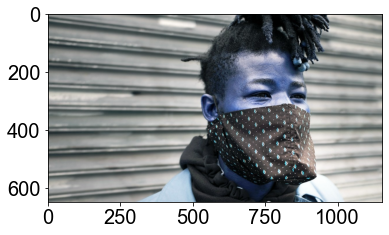

H5B1PXKDL7E4VFI3A2M0.jpg cannot be formatted


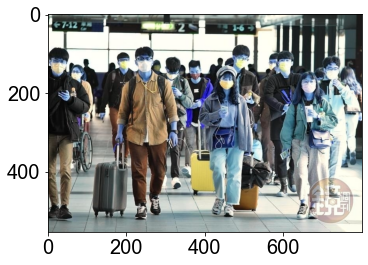

78LGWRXITQB164VPMNF2.jpg cannot be formatted


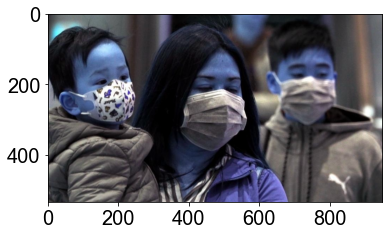

C19GKOAL0N567IMEBWZ3.jpg cannot be formatted


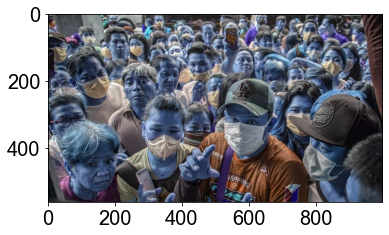

A3RIED7CHW0V8NJ6OUS9.jpg cannot be formatted


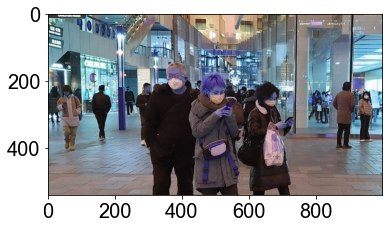

E0HZJ4Y6BDLAIM2PFK3N.jpg cannot be formatted


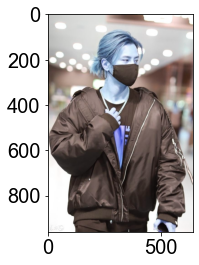

O5RU3HLID1M6J70KP2TX.jpg cannot be formatted


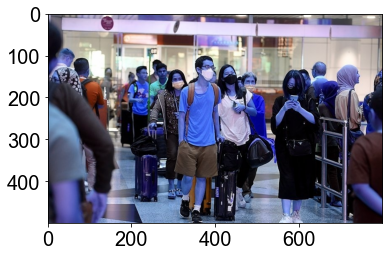

0B2QYGK96UD5S71RTHPX.jpg cannot be formatted


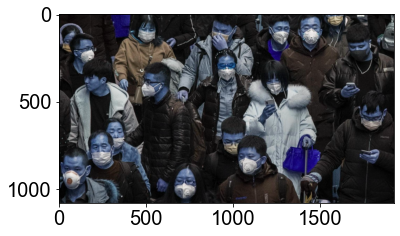

QF9ARXUPKSW7G8410E62.jpg cannot be formatted


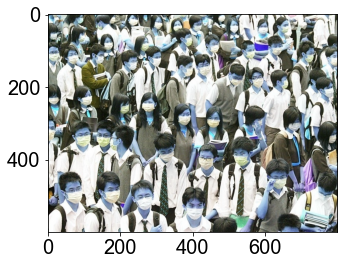

TU02318AD6BE95LMJKX7.jpg cannot be formatted


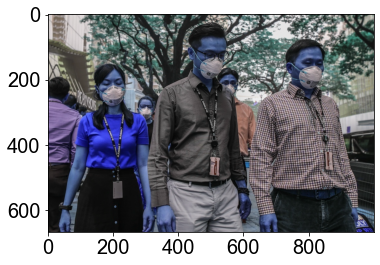

5X3OQU7DKG09S6BCWFE4.jpg cannot be formatted


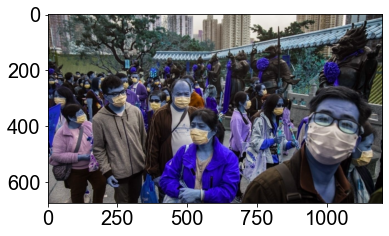

GVCSLM9QR7DOJETNBHZ4.jpg cannot be formatted


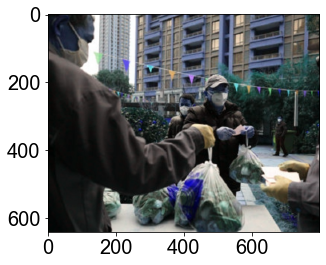

QJULO38P4DGTBNYZ05VR.jpg cannot be formatted


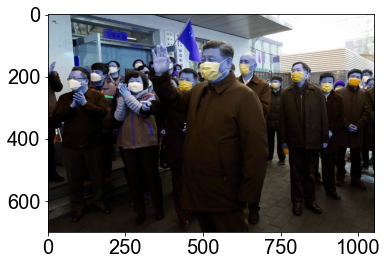

2ETKUNP1937LV84DY65I.jpg cannot be formatted


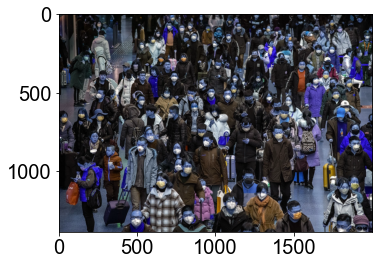

2ETKUNP1937LV84DY65I.jpg cannot be formatted


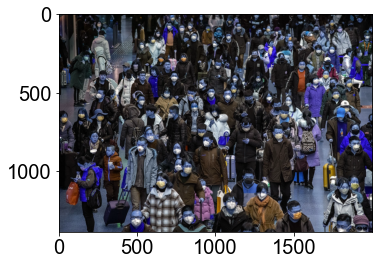

2ETKUNP1937LV84DY65I.jpg cannot be formatted


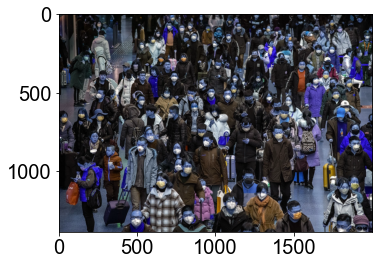

2ETKUNP1937LV84DY65I.jpg cannot be formatted


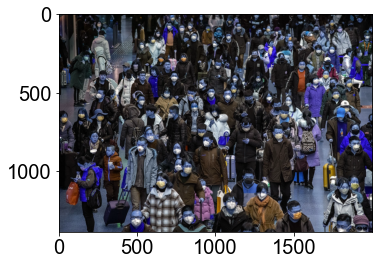

2ETKUNP1937LV84DY65I.jpg cannot be formatted


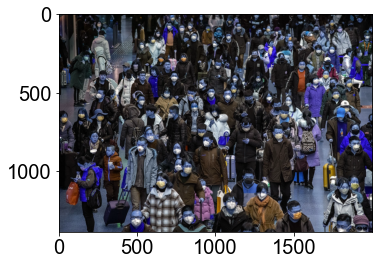

In [106]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
img_size=224#50
data=[]
path="../Dataset/compiled_data/"
to_drop = []
    
for index,row in train_face_eval.iterrows(): # only extract face annotation (NOT mask annotations)
    # reads in the image and converts it to greyscale 
    img_array=cv2.imread(row['image_file_dir']+row['name'],cv2.COLOR_BGR2RGB)#IMREAD_GRAYSCALE)#
    # crops the image to only include the face 
    crop_image = img_array[row['x2']:(row['y2']+row['x2']),
                           row['x1']:(row['y1']+row['x1'])]
    # resizes the image to 50x50
    try:
        new_img_array=cv2.resize(crop_image,(img_size,img_size))
    #         plt.imshow(new_img_array)
    #         plt.show()
        data.append([new_img_array,row['classname']])#new_img_array[1]])
    except:
        print(row['name'],"cannot be formatted")
        plt.imshow(img_array)
        plt.show()
        # keep track of those without the appropriate information and drop from the dataframe
        to_drop.append(index)
        data.append(-1)
    





In [107]:
# Exclude annotations that could not be formatted
train_face_eval = train_face_eval.drop(to_drop)

initial_len = len(data)
data = [x for x in data if x != -1]

print("Dropped",len(to_drop),"images from train_face_eval")
print("Dropped",initial_len-len(data),"faces from data")



Dropped 18 images from train_face_eval
Dropped 18 faces from data


In [108]:
# Extracts labels (mask/no mask) and features (50x50 vector of face image) and places them into x and y lists respectively
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)
print("y:",y)
print("x:",x[0:5])




y: [0 1 1 ... 0 0 0]
x: [array([[[162, 158, 164],
        [149, 145, 151],
        [123, 120, 125],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       [[135, 131, 137],
        [124, 120, 126],
        [ 80,  77,  83],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       [[153, 151, 157],
        [ 96,  94, 100],
        [ 65,  62,  68],
        ...,
        [162, 159, 165],
        [160, 158, 164],
        [160, 158, 164]],

       ...,

       [[116, 114, 120],
        [116, 114, 120],
        [117, 115, 121],
        ...,
        [ 61,  45,  46],
        [ 61,  45,  46],
        [ 54,  38,  39]],

       [[117, 115, 121],
        [116, 114, 120],
        [116, 113, 119],
        ...,
        [ 63,  46,  47],
        [ 64,  47,  48],
        [ 62,  44,  45]],

       [[115, 113, 119],
        [115, 113, 119],
        [116, 113, 120],
        ...,
        [ 58,  42,  43],
        [ 66,  49,  49],

In [109]:
x_test = np.asarray(x[0:160])# set of 50x_train50 arrays representing pix_trainel intensities for each image
print("x.shape",x_test.shape)
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
y_test = y[0:160]
print("y:",y_test)



x.shape (160, 224, 224, 3)
y: [0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1]


In [110]:
# perform prediction
pred = new_model.predict(x=x_test,batch_size=32)



In [111]:
from sklearn import metrics

d = metrics.classification_report(y_test,
                                  [int(round(x,0)) for x in pred[:,0]],
                                  output_dict = True
                                 )

d = pd.DataFrame(d)
d = d.apply(lambda x: round(x,4))

display(d)



0         1  accuracy  macro avg  weighted avg
precision   0.1818    0.8043    0.7188     0.4931        0.6837
recall      0.1290    0.8605    0.7188     0.4947        0.7188
f1-score    0.1509    0.8315    0.7188     0.4912        0.6996
support    31.0000  129.0000    0.7188   160.0000      160.0000

In [79]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,[int(round(x,0)) for x in pred[:,0]]) # true, predicted

array([[  3,  28],
       [  0, 129]])

TN: 3  FP: 28  FN: 0  TP: 129


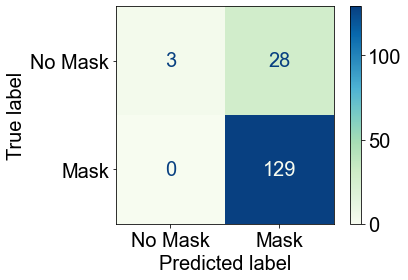

In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial" # set default font to Arial
matplotlib.rcParams['font.family'] = "sans-serif" # ALWAYS use sans-serif fonts
matplotlib.rcParams['font.size'] = 20
fig, ax = plt.subplots()

cm = confusion_matrix(y_test,[int(round(x,0)) for x in pred[:,0]])#pred,y_test[:,0])
tn, fp, fn, tp = cm.ravel()
print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No Mask","Mask"])
disp.plot(cmap='GnBu',ax=ax)
title = 'Mask Detection Model'
# ax.set_title('Title')
plt.savefig('plots/'+title.replace(" ","_")+"_confusion_matrix-rmw_on_diverse_data.png",dpi=300,bbox_inches="tight",transparent=True)


